<a href="https://colab.research.google.com/github/SantosAbimaelRomero/Sales-Preditions/blob/main/Sales_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import set_config
set_config(display='diagram')

In [2]:
original = pd.read_csv('Project Files/sales_predictions.csv')
original.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data Prep

In [3]:
df = original.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
df.duplicated().sum()

0

No Duplicates

In [6]:
df.isna().sum()
# Item_Weight and Outlet_Size are missing data

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In my 'Sales Presentation' file, it can be seen how I came to the following code in detail.

In summary, I found patterns in what the outlet size could most likely be based on both outlet location type and outlet type.

In [7]:
for index in range(len(df)):
    if df.loc[index, 'Outlet_Location_Type'] == 'Tier 2':
        df.loc[index, 'Outlet_Size'] = 'Small'
    elif df.loc[index, 'Outlet_Type'] == 'Grocery Store':
        df.loc[index, 'Outlet_Size'] = 'Small'
    elif df.loc[index, 'Outlet_Type'] == 'Supermarket Type2':
        df.loc[index, 'Outlet_Size'] = 'Medium'
    elif df.loc[index, 'Outlet_Type'] == 'Supermarket Type3':
        df.loc[index, 'Outlet_Size'] = 'Medium'


In [8]:
df.isna().sum()
# Item_Weight is missing data

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

I will remove the rows missing values in the Item_Weight column as I still keep ~83% of the data as discovered during the data visualization and the importance of keeping this value accurate to ensure predictions are as reliable as possible

In [9]:
df.dropna(inplace=True)

In [10]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7060 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            7060 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           7060 non-null   object 
 3   Item_Visibility            7060 non-null   float64
 4   Item_Type                  7060 non-null   object 
 5   Item_MRP                   7060 non-null   float64
 6   Outlet_Identifier          7060 non-null   object 
 7   Outlet_Establishment_Year  7060 non-null   int64  
 8   Outlet_Size                7060 non-null   object 
 9   Outlet_Location_Type       7060 non-null   object 
 10  Outlet_Type                7060 non-null   object 
 11  Item_Outlet_Sales          7060 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 717.0+ KB


## Ordinal Encoding

In [12]:
df1 = df.copy()

In [13]:
df1.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Outlet_Size can be ordinally encoded.

In [14]:
df1['Outlet_Size'].value_counts()

Small     4270
Medium    1858
High       932
Name: Outlet_Size, dtype: int64

In [15]:
df1['Outlet_Size'].replace({'Small':0, 'Medium':1, 'High':2}, inplace=True)
df1['Outlet_Size'].value_counts()

0    4270
1    1858
2     932
Name: Outlet_Size, dtype: int64

I considerd other columns, like "Outlet_Type", to also ordinally encode but have chosen against this as the categories inside this column overlap with other features. For example, a Tier 1 in "Outlet_Type" can be either small or medium but a Tier 2 can also be medium and high, while Tier 3 is all three, small, medium, and high, so I can't clearly identify a proper tier of which should come first and which last. 

# Preprocessing

## Train/Test Split

In [112]:
# Feature Matrix
X = df1.drop(columns='Item_Outlet_Sales')
# Target Vector
y = df1['Item_Outlet_Sales']

In [113]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Selectors

In [18]:
# Object Column Filter
obj_filter = make_column_selector(dtype_include='object')
# Int and Float Column Filter
num_filter = make_column_selector(dtype_include='number')

## Transformers

In [19]:
# Scaler
scaler = StandardScaler()
# One Hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [20]:
print(df1['Item_Weight'].mean())
print('')
df1['Item_Weight'].median()

12.857645184135977



12.6

In [21]:
print(df1['Item_Weight'].min())
df1['Item_Weight'].max()

4.555


21.35

## ColumnTransformers

In [22]:
# Tuples for Column Transformer
num_tuple = (scaler, num_filter)
obj_tuple = (ohe, obj_filter)
# ColumnTransformer
preprocessor = make_column_transformer(num_tuple, obj_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735C610>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735CD30>)])

# Transform Data

In [114]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735C610>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735CD30>)])

In [115]:
X_train_post = preprocessor.transform(X_train)
X_test_post = preprocessor.transform(X_test)

# Post Processing

In [25]:
X_train_viz = pd.DataFrame(X_train_post)
X_test_viz = pd.DataFrame(X_test_post)

In [26]:
print(f"""Missing values in training data:
{X_train_viz.isna().sum().sum()}
Data Type in Training data:
{X_train_post.dtype}

Missing values in test data:
{X_test_viz.isna().sum().sum()}
Data Type in Test Data:
{X_test_post.dtype}
""")

Missing values in training data:
0
Data Type in Training data:
float64

Missing values in test data:
0
Data Type in Test Data:
float64



## Training Data

In [27]:
X_train_viz.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576
count,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00,...,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00,5295.00
mean,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,...,0.13,0.13,0.13,0.13,0.26,0.39,0.34,0.08,0.79,0.14
std,1.00,1.00,1.00,1.00,1.00,0.03,0.03,0.03,0.02,0.02,...,0.34,0.34,0.34,0.34,0.44,0.49,0.47,0.27,0.41,0.34
min,-1.79,-1.32,-1.76,-2.06,-0.74,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.88,-0.77,-0.75,-0.54,-0.74,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
50%,-0.06,-0.24,0.02,0.22,-0.74,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
75%,0.86,0.59,0.71,0.98,0.67,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00
max,1.83,5.08,2.02,1.29,2.07,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Test Data

In [28]:
X_test_viz.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576
count,1765.00,1765.00,1765.00,1765.00,1765.00,1765.00,1765.00,1765.0,1765.0,1765.00,...,1765.00,1765.00,1765.00,1765.00,1765.00,1765.00,1765.00,1765.00,1765.0,1765.00
mean,-0.01,-0.01,0.03,-0.04,0.01,0.00,0.00,0.0,0.0,0.00,...,0.13,0.13,0.13,0.13,0.26,0.40,0.34,0.08,0.8,0.12
std,1.00,1.00,1.01,1.01,1.02,0.03,0.02,0.0,0.0,0.03,...,0.34,0.34,0.33,0.34,0.44,0.49,0.48,0.28,0.4,0.33
min,-1.78,-1.32,-1.75,-2.06,-0.74,0.00,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
25%,-0.90,-0.78,-0.75,-0.54,-0.74,0.00,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00
50%,-0.06,-0.24,0.08,0.22,-0.74,0.00,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00
75%,0.84,0.58,0.76,0.98,0.67,0.00,0.00,0.0,0.0,0.00,...,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.0,0.00
max,1.83,4.81,2.02,1.29,2.07,1.00,1.00,0.0,0.0,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00


# Prediction Model

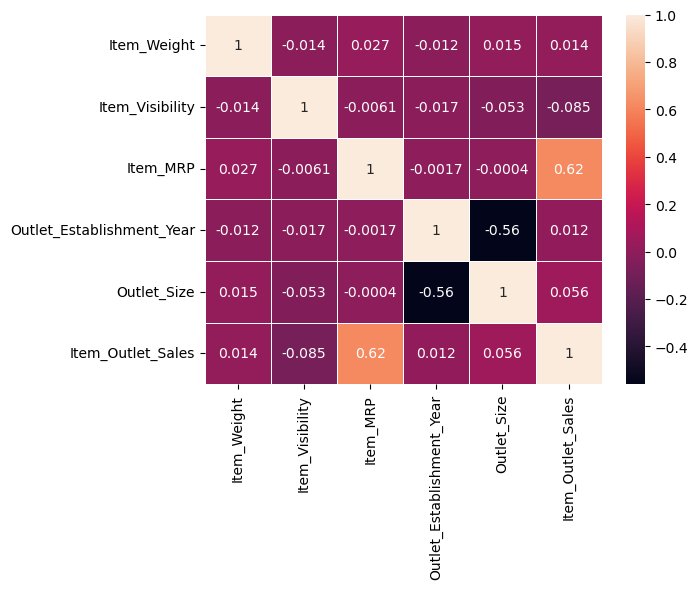

In [29]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

forcorr = df1.select_dtypes(include=numerics)
sns.heatmap(data=forcorr.corr(), annot=True, linewidth=0.5);

Quickly observing any correlation between the numerical data columns, the only two columns with any significant correlation is Item MRP and Item Outlet Sales.

## Functions

In [30]:
# Evaluation Function
def eval(yog, y_pred, i):
    mae = mean_absolute_error(yog, y_pred)
    mse = mean_squared_error(yog, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yog, y_pred)
    print(f"""{i}
    MAE Score: {mae}
    MSE Score: {mse}
    RMSE Score: {rmse}
    R2 Score: {r2}
    """)

In [31]:
# Parameter Change Function
def mod(tree_model, arg):
    for i in arg:
        if arg == est_list:
            tree = tree_model(n_estimators=i, random_state=42)
        elif arg == depth_list:
            tree = tree_model(max_depth=i, random_state=42)
        elif arg == max_feat:
            tree = tree_model(max_features=i, random_state=42)
        pipe = make_pipeline(preprocessor, tree)
        pipe.fit(X_train, y_train)
        tr = pipe.score(X_train, y_train)
        ts = pipe.score(X_test, y_test)
        scores.loc[i, 'Train Score'] = tr
        scores.loc[i, 'Test Score'] = ts

In [32]:
# Visualization Function
def viz(list_type):
    fig, axes = plt.subplots(ncols=1, figsize=(8, 5))
    axes.grid(c='grey')

    sns.lineplot(data=scores, x=list_type, y='Test Score', label='Test Data')
    sns.lineplot(data=scores, x=list_type, y='Train Score', label='Train Data')
    axes.set_xticks(list_type)
    axes.set_ylabel('R2 Score', fontsize=15)
    axes.set_xlim(left=min(list_type), right=max(list_type))
    axes.set_ylim(bottom=min(scores['Test Score'] - 0.05), top=(max(scores['Train Score']) + 0.05))
    plt.legend()
    if list_type == depth_list:
        axes.set_xlabel('Depth', fontsize=15)
    elif list_type == est_list:
        axes.set_xlabel('Number of Estimators', fontsize=15)
    elif list_type == max_feat:
        axes.set_xlabel('Number of Features', fontsize=15)

## Linear Regression Model

In [33]:
# Instantiate
linreg = LinearRegression()
# Pipeline
lr_pipe = make_pipeline(preprocessor, linreg)
# Fit Pipeline model to data
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735C610>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735CD30>)])),
                ('linearregression', LinearRegression())])

In [34]:
# Predictions
train_pred = lr_pipe.predict(X_train)
test_pred = lr_pipe.predict(X_test)

In [35]:
# Evaluation
eval(y_train, train_pred, 'Training Data')
eval(y_test, test_pred, 'Test Data')

Training Data
    MAE Score: 666.7120836638338
    MSE Score: 822760.200515826
    RMSE Score: 907.0612992052004
    R2 Score: 0.6455256350817679
    
Test Data
    MAE Score: 4828177395814.791
    MSE Score: 1.968066984609201e+27
    RMSE Score: 44362900994064.86
    R2 Score: -8.06599518300937e+20
    


R2
___
Using a `Linear Regression` model, we can see that our model can only account for little more than 56% of the data. Which is not a good sign for a useful model as it only accounts for little more than half the data.

MAE / RMSE
___
Looking at the `MAE` and `RMSE`, they are about ₹200 to ₹300 apart. This means there aren't many large errors for `RMSE` to punish, but we still have an error margin of ~₹800 to ~₹1,100 from our models predictions to the actual reported total outlet sales of any given item. Which in the context of the " Item_Outlet_Sales " column, which is our target vector, that is a very large amount. In some cases, the model is potentially doubling the predicting sales of an item. So, despite the `MAE` and `RMSE` being seemingly close together, the actual values they hold are far too large for me to recommend this model.

## Random Forest Regression Model

### Initial Attempt

In [67]:
# Instantiate
rf = RandomForestRegressor(random_state=42)
# Pipeline
rf_pipe = make_pipeline(preprocessor, rf)
# Fit model to Data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735C610>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735CD30>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [68]:
# Predictions
train_pred = rf_pipe.predict(X_train)
test_pred = rf_pipe.predict(X_test)

In [69]:
# Evaluation
eval(y_train, train_pred, 'Train Data')
eval(y_test, test_pred, 'Test Data')

Train Data
    MAE Score: 298.5795792509915
    MSE Score: 177455.44234134973
    RMSE Score: 421.2546051277656
    R2 Score: 0.9235458822804058
    
Test Data
    MAE Score: 792.6248847082153
    MSE Score: 1254317.718758207
    RMSE Score: 1119.963266700389
    R2 Score: 0.48592599964396055
    


R2
___
With default parameters we can see the model is `overfitting` as it has a near perfect score in the training data despite having slightly ove 0.54 on the Test data. This must be accounted for while fine tuning the model.

MAE vs RMSE
___
The error in the train data is significantly smaller than the error in the test data, most likely due to `high variance`. The values are too large for the model in its current state to be of any use.

### Fine Tuning Model

In [39]:
# Checking current parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [40]:
# I will start by checking different values for n_estimators
# Estimator list
est_list = [50, 60, 70, 80, 90, 100, 110, 120, 130]
# Scores DataFrame
scores = pd.DataFrame(index=est_list, columns=['Test Score', 'Train Score'])
# Estimator Function
mod(RandomForestRegressor, est_list)

In [41]:
# organize DataFrame from Largest to Smallest
scores = scores.sort_values(by='Test Score', ascending=False)
scores.head()

,Test Score,Train Score
100,0.489959,0.924003
90,0.488503,0.923534
120,0.488393,0.924136
130,0.488293,0.924377
110,0.488203,0.924009


The R2 peaks at 130 estimators, though there is still a clear sign of overfitting that needs to be addressed.

In [42]:
# Depth list
depth_list = list(range(2, 31))
# Scores DataFrame
scores = pd.DataFrame(index=depth_list, columns=['Test Score', 'Train Score'])
# Testing Loop Function
mod(RandomForestRegressor, depth_list)

In [43]:
# Check scores DataFrame for highest Score
scores = scores.sort_values(by='Test Score', ascending=False)
scores.head()

,Test Score,Train Score
5,0.537838,0.532969
6,0.537521,0.546272
4,0.53734,0.521488
7,0.536119,0.560866
8,0.533833,0.577062


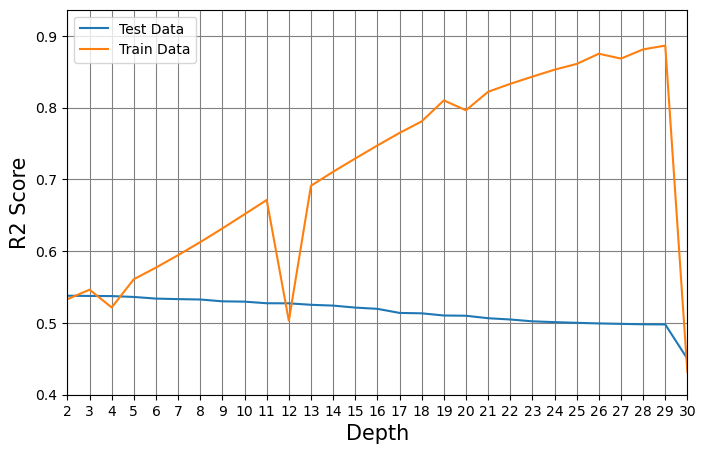

In [44]:
# Lineplot Visualization
viz(depth_list)

Here we see an interesting visual, where the scores seem to align most at depths 5, 20, and 30.

Depth 5 is too low while at depth 30 it looks like the model is failing and crashing, I will choose depth 20 as the best option, despite having a lower score than at depth 5.

In [45]:
# List of num of features
max_feat = list(range(5, 30))
# Scores DataFrame
scores = pd.DataFrame(index=max_feat, columns=['Test Score', 'Train Score'])
# Run mod function
mod(RandomForestRegressor, max_feat)

In [46]:
scores=scores.sort_values(by='Test Score', ascending=False)
scores.head()

,Test Score,Train Score
27,0.495728,0.925673
29,0.493958,0.925487
20,0.491841,0.924826
26,0.490683,0.925328
28,0.490273,0.9245


The highest test score is at 27 but we still see the model overfitting by a significant margin.

### Reducing Features

Because of the overfitting, I believe reducing any unnecessary columns might help with predictions.

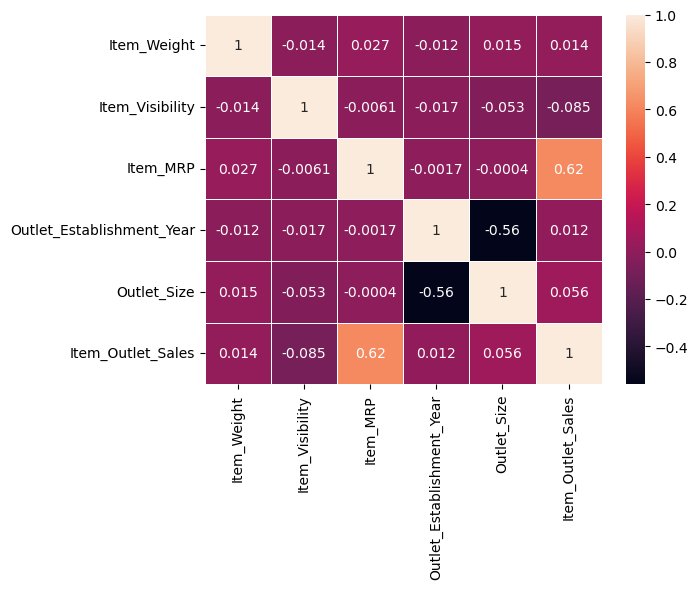

In [51]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

forcorr = df1.select_dtypes(include=numerics)
sns.heatmap(data=forcorr.corr(), annot=True, linewidth=0.5);

In [79]:
df2 = df1.drop(columns=['Item_Weight', 'Item_Visibility']).copy()

In [80]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7060 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            7060 non-null   object 
 1   Item_Fat_Content           7060 non-null   object 
 2   Item_Type                  7060 non-null   object 
 3   Item_MRP                   7060 non-null   float64
 4   Outlet_Identifier          7060 non-null   object 
 5   Outlet_Establishment_Year  7060 non-null   int64  
 6   Outlet_Size                7060 non-null   int64  
 7   Outlet_Location_Type       7060 non-null   object 
 8   Outlet_Type                7060 non-null   object 
 9   Item_Outlet_Sales          7060 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 606.7+ KB


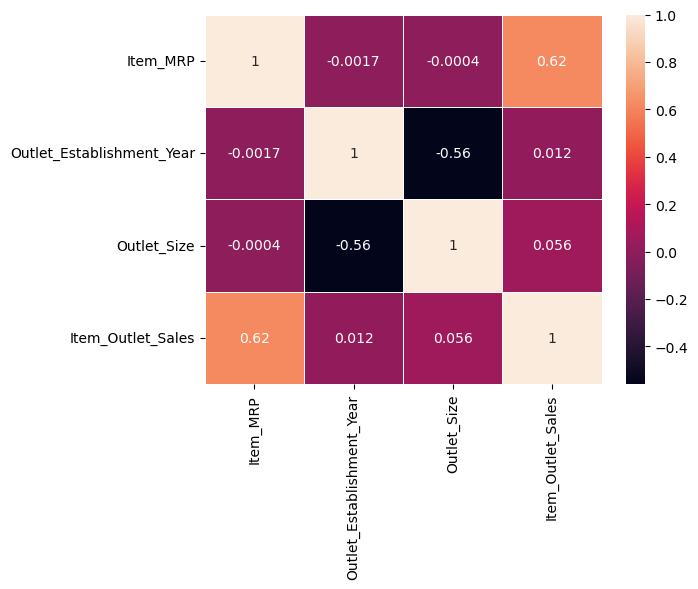

In [81]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

forcorr = df2.select_dtypes(include=numerics)
sns.heatmap(data=forcorr.corr(), annot=True, linewidth=0.5);

Now we only have features that have significant correlation, item mrp with item outlet sales and outlet size with outlet establishment year.

### Testing Tuned Model with Reducced Features

In [119]:
# Feature Matrix
X = df2.drop(columns='Item_Outlet_Sales')
# Target Vector
y = df2['Item_Outlet_Sales']

In [120]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [121]:
# Preprocess new data
preprocessor.fit(X_train)

X_train_post = preprocessor.transform(X_train)
X_test_post = preprocessor.transform(X_test)

In [122]:
# Instantiate
rf = RandomForestRegressor(max_depth=27, random_state=42)
# Pipeline
rf_pipe = make_pipeline(preprocessor, rf)
# Fit model to Data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735C610>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001DB6735CD30>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=27, random_state=42))])

In [123]:
# Predictions
train_pred = rf_pipe.predict(X_train)
test_pred = rf_pipe.predict(X_test)

In [124]:
# Evaluation
eval(y_train, train_pred, 'Train Data')
eval(y_test, test_pred, 'Test Data')

Train Data
    MAE Score: 492.04237121173725
    MSE Score: 447569.26839640783
    RMSE Score: 669.0061796399252
    R2 Score: 0.8071712364401337
    
Test Data
    MAE Score: 771.7936116856777
    MSE Score: 1202132.3440228344
    RMSE Score: 1096.4179604616272
    R2 Score: 0.5073138377882318
    


By limiting the max_depth and reducing the features we see minimal improvement on the test data but significant reduction in the train data in regards to the R2 score. Overall didn't help imrove the model

# Final Thoughts

I believe the Linear Regreesion model to be the better option for predicting this data.

My reasoning resides on how it performed against a Random Tree Regression Model.

The Random Tree Regression model kept overfitting even after I made adjustments by a significant margin.
The closer I tried make the R2 scores for the Training data and Test data, the worse the score had to get.
On the heatmap in my Predictions file you can see there is very little correlation with any of the numerical columns
The categorical columns don't assist much in putting it all together, ultimately just creating too much noise for the 
Tree Regression Model to effectively work with other forms of data.


The linear regression model managed to keep the R2 scores close together and overall higher than when the same was 
accomplished with the Tree Regression Model.